In [28]:
%matplotlib notebook
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

def get_ordered_colors(cmap, n, lb=0, ub=1):
    cmap = cm.get_cmap(cmap)
    return cmap(np.linspace(lb, ub, n))

Our aim here is to investigate the circumstances under which recurrent inhibition can narrow and perhaps stabilize the range of possible propagation speeds of a feedforward excitatory network.

Let's begin by considering a single LIF neuron embedded in an excitatory layer of cells within the feedforward network.

### LIF neuron governing equation

A current-based LIF neuron has the following governing equation:

$$ \tau \dot{V}(t) = -V(t) + \frac{\tau}{C} I(t) $$

The solution has the general form:

$$ V(t) = V_0 + \frac{1}{C} \int_{0}^{t} I(t') e^{-(t-t')/ \tau } dt' $$

When driven with constant current $I_0$, the voltage is:

$$ V(t) = V_0 + \frac{I_0}{C} \int_{0}^{t} e^{-(t-t')/ \tau } dt' \\
        = V_0 + \frac{I_0 \tau}{C} (1 - e^{-t/\tau}) $$
        

### Dynamics of an excitatory cell receiving feedforward excitation and global inhibition

Suppose a neuron has been driven for a long time with current $I_{i}$, representing the global inhibition supplied by the inhibitory pool given steady-state propagating dynamics of the chain:

$$ V(t) = V = V_0 + \frac{I_i \tau}{C} $$

At time $t_0$, the excitation propagating along the chain begins to excite the neuron in question. Introduce a new component to the input current, $I_e$ such that $I(t > t_0) = I_i + I_e$:

$$ V(t > t_0) = V_0 + \frac{I_i \tau}{C} + \frac{I_e \tau}{C} (1 - e^{-t/\tau}) $$

To calculate time-to-threshold, solve:

$$ V_{th} = V_0 + \frac{I_i \tau}{C} + \frac{I_e \tau}{C} (1 - e^{-t^*/\tau}) $$

$$ (1 - e^{-t^*/\tau}) = \left(V_{th} - V_0 - \frac{I_i \tau}{C}\right) \frac{C}{\tau I_e} $$

$$ t^* = - \tau \log\left(1 - \frac{C}{\tau I_e} \left(V_{th} - V_0 - \frac{I_i \tau}{C}\right)\right) $$

### Model of the inhibitory pool

We have not yet specified the coupling from the excitatory cells to the inhibitory pool and back yet, but let us assume that E cells are coupled to I cells with sufficient strength so that individual spikes from E cells always evoke spikes from their coupled I cells. In this limit, the frequency of spikes in an I cell is linear with the frequency of spikes of an E cell that drives it, i.e. a firing rate approximation is suitable.

If we further assume that coupling from I cells to E cells in the chain is global and uniform, then $I_i(t)$ is a linear function of $I_e(t)$ with some time lag.

For ease of calculation, let us assume $I_i(t) = A I_e(t)$, where $A < 0$. We then have:

$$ t^* = -\tau \log\left[1 - \frac{C}{\tau I_e(t)} \left(V_{th} - V_0 - \frac{\tau A I_e(t)}{C}\right)\right] \\ 
        = -\tau \log\left[1 - \left(\frac{C \left(V_{th} - V_0 \right) }{\tau I_e(t)} - A\right)\right] $$


Let us define $\alpha = C \left(V_{th} - V_0 \right) / \tau$ and simplify a bit:

$$ t^*  = -\tau \log\left[1 + A - \frac{\alpha}{I_e(t)}\right] $$

Here, $A < 0$, $\alpha > 0$, and $I_e(t) \geq 0$ by definition.

<IPython.core.display.Javascript object>


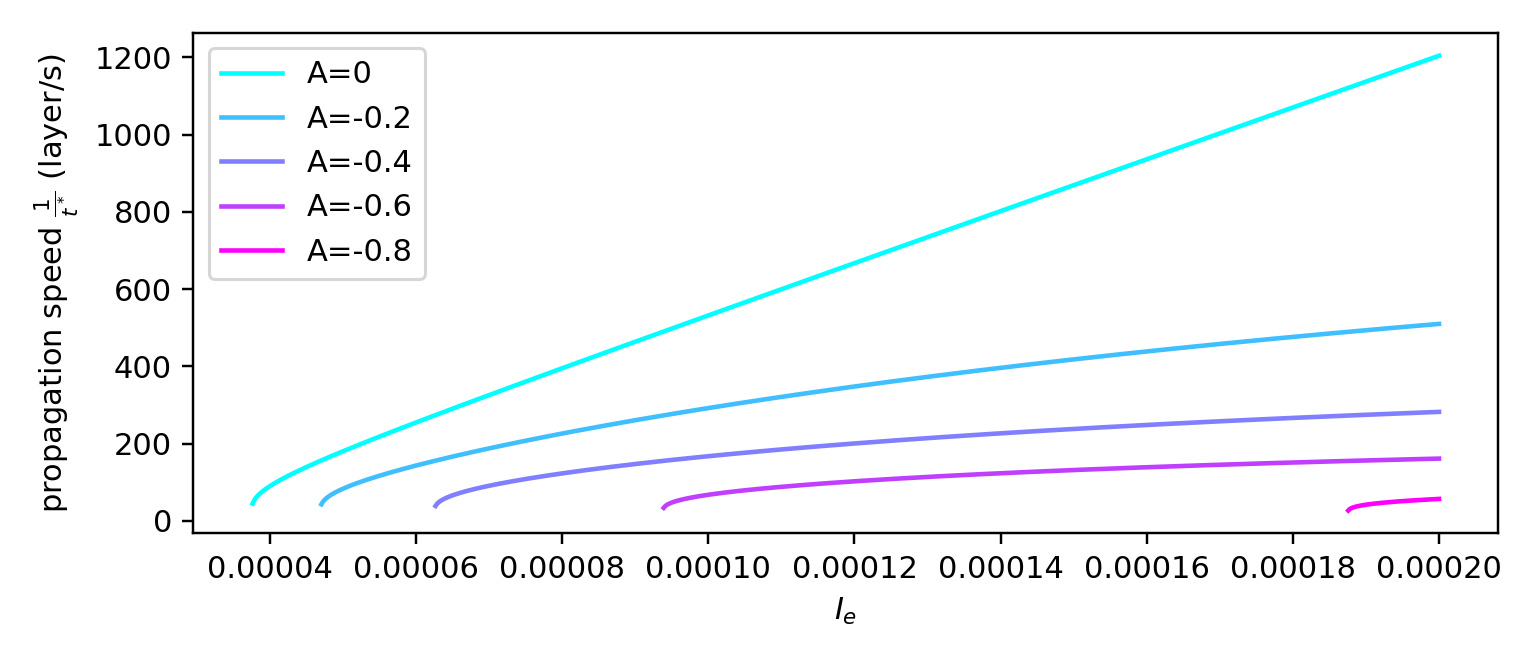

Text(0.5, 0, '$I_e$')

In [29]:
tau = 4e-3
c = 1e-6
v_th = -0.5
v_0 = -0.65

alpha = c / tau * (v_th - v_0)

def t_star(a, i_e):
    return -tau * np.log(1 + a - alpha / i_e)

def prop_speed(a, i_e):
    return 1/t_star(a, i_e)

fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)

i_e = np.linspace(1e-8, 0.2e-3, 1000)

colors = get_ordered_colors('cool', 5)

for i, a in enumerate([0, -0.2, -.4, -.6, -.8]):
    ax.plot(i_e, prop_speed(a, i_e), c=colors[i], label=f'A={a}')
ax.legend()
ax.set_ylabel(r'propagation speed $\frac{1}{t^*}$ (layer/s)')
ax.set_xlabel(r'$I_e$')

Note here that a physiologically realistic activation time of a neuron in such a feed-forward network might be ~1.5-5 ms, corresponding to propagation speeds of 200-660 layers/sec. I estimated this number from the duration of the voltage ramp-ups of HVC(RA) cells recorded in Long et al., 2010, which are roughly 1.5-5 ms given that the ISI of bursting HVC(RA) cells is known to be ~2 ms, as reported in Ross et al., 2017.

### Structured inhibition

For a structured inhibiton network, we can repeat our calculations above, but now assume that at time $t > t_0$, the current is simply $I_e(t)$ because the structure of the inhibition will shield the neurons being excited from inhibition at time $t_0$ and a short while after. To capture the fact that the inhibitory current may not drop off right as excitatory current begins, we model the inhibitory current as ending at a time $\Delta t$ relative to the onset of the excitatory current. We then have:

$$ V_{th} = V_0 + \frac{I_i \tau}{C} e^{-(t^* + \Delta t)/\tau} + \frac{I_e \tau}{C} (1 - e^{-t^*/\tau}) $$

$$ V_{th} - V_0 = \frac{\tau (I_i e^{-\Delta t/\tau} - I_e)}{C} e^{-t^*/\tau} + \frac{I_e \tau}{C} $$

$$ \frac{C(V_{th} - V_0)}{\tau} - I_e = (I_i e^{-\Delta t/\tau} - I_e) e^{-t^*/\tau}$$

Set $I_i = A I_e$ where $A < 0$:

$$ \frac{1}{I_e (A e^{-\Delta t/\tau} - 1)} \left( \frac{C(V_{th} - V_0)}{\tau} - I_e \right) = e^{-t^*/\tau}$$

$$ -\tau \log \left[ \frac{1}{I_e (A e^{-\Delta t/\tau} - 1)} \left( \frac{C(V_{th} - V_0)}{\tau} - I_e \right) \right] = t^* $$


$$ t^* = -\tau \log \left[ \frac{1}{1 - A e^{-\Delta t/\tau}} \left(1 -  \frac{C(V_{th} - V_0)}{\tau I_e} \right) \right] $$

Below we graph $\frac{1}{t^*}$ for different values of $A$ and $\Delta t$ chosen so that excitatory and inhibitory currents overlap in time. In this parameter regime, strong recurrent inhibition delays time-to-spike when the excitation is strong, but decays over time, ensure a spike will occur. When instead the excitation is weak, the recurrent inhibition is minimal, permitting the cell to spike as if it were uninhibited.

In particular, notice the flatness of the propagation speed as a function of the input excitatory current.

<IPython.core.display.Javascript object>


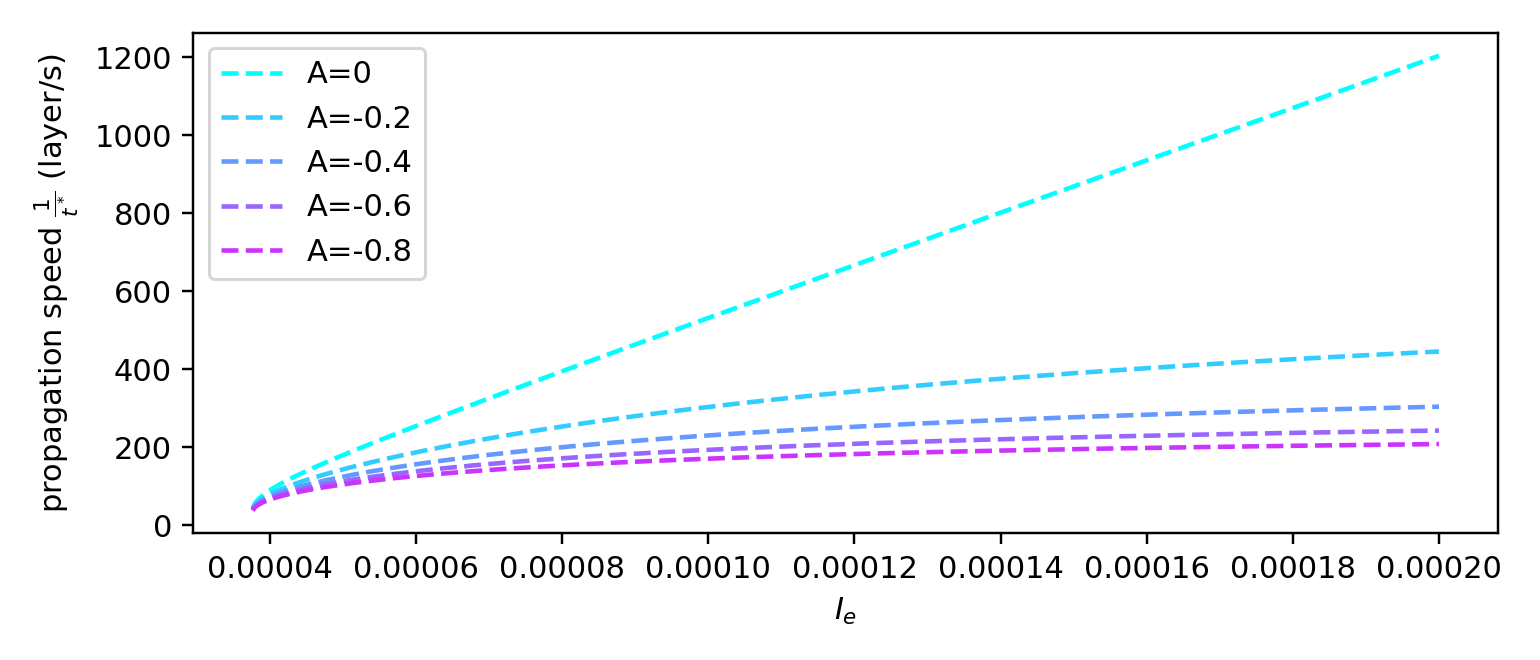

Text(0.5, 0, '$I_e$')

In [26]:
delta_t = -3e-3

def t_star_structed(a, i_e):
    return -tau * np.log((1 - alpha / i_e) / (1 - a * np.exp(-delta_t / tau)))

def prop_speed_structed(a, i_e):
    return 1 / t_star_structed(a, i_e)

fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)

colors = get_ordered_colors('cool', 6)

for i, a in enumerate([0, -0.2, -.4, -.6, -.8]):
    ax.plot(i_e, prop_speed_structed(a, i_e), '--', c=colors[i], label=f'A={a}')
ax.legend()
ax.set_ylabel(r'propagation speed $\frac{1}{t^*}$ (layer/s)')
ax.set_xlabel(r'$I_e$')

### Comparison of mean propagation speed of structured and unstructured networks
Below, we compare the mean propagation speeds of networks with structured (dashed) and unstructured (solid) inhibition for different values of A.

<IPython.core.display.Javascript object>


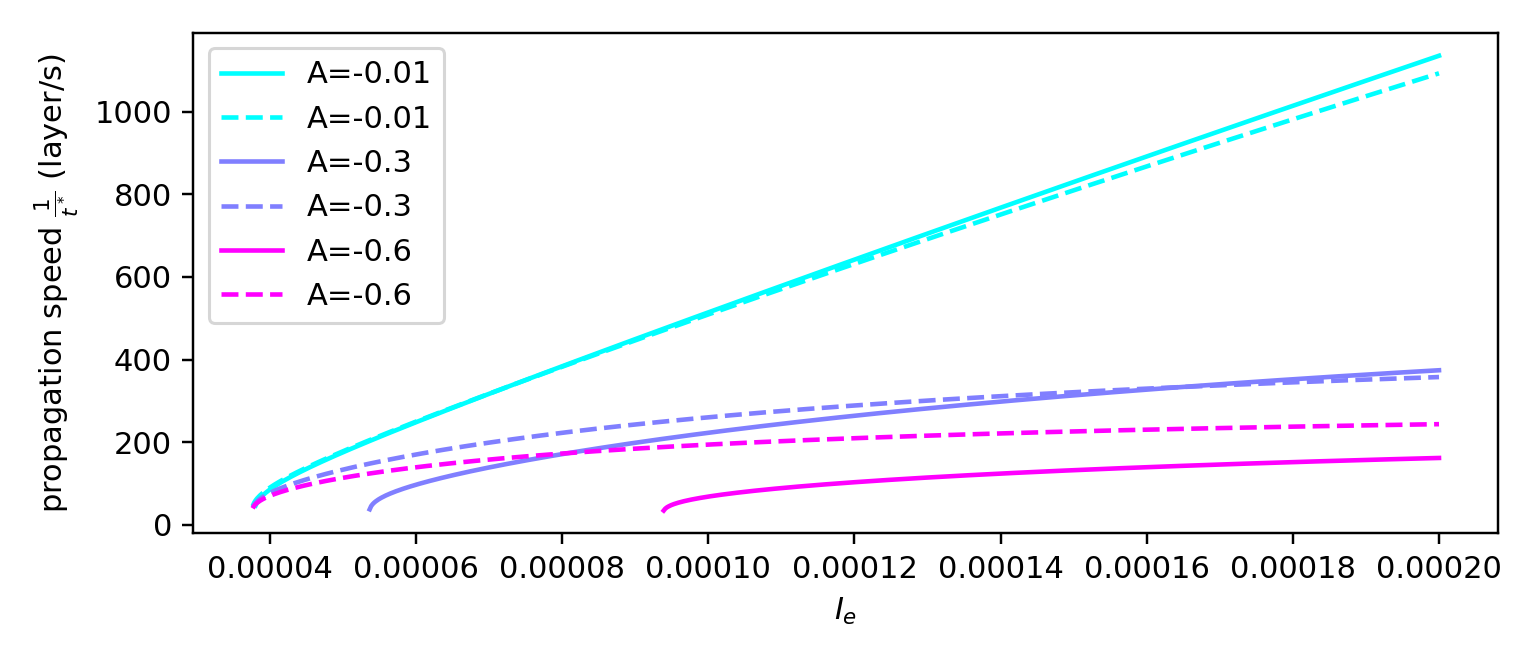

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)

colors = get_ordered_colors('cool', 3)

for i, a in enumerate([-0.01, -0.3, -.6]):
    ax.plot(i_e, prop_speed(a, i_e), c=colors[i], label=f'A={a}')
    ax.plot(i_e, prop_speed_structed(a, i_e), '--', c=colors[i], label=f'A={a}')

ax.set_ylabel(r'propagation speed $\frac{1}{t^*}$ (layer/s)')
ax.set_xlabel(r'$I_e$')
ax.legend()